In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import seaborn as sns
import itertools 
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import os

rc={'font.size': 8, 'axes.labelsize': 8, 'legend.fontsize': 10.0, 
    'axes.titlesize': 32, 'xtick.labelsize': 20, 'ytick.labelsize': 16}
plt.rcParams.update(**rc)
import seaborn as sns; sns.set()
sns.set_style("whitegrid")
mpl.rcParams['axes.linewidth'] = 0.0 #set the value globally

import torch
from transformers import AutoModelForSequenceClassification
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer


import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### Utilties

In [3]:
#@title Utilities

def get_adjmat(mat, input_tokens):
    n_layers, length, _ = mat.shape
    adj_mat = np.zeros(((n_layers+1)*length, (n_layers+1)*length))
    labels_to_index = {}
    for k in np.arange(length):
        labels_to_index[str(k)+"_"+input_tokens[k]] = k

    for i in np.arange(1,n_layers+1):
        for k_f in np.arange(length):
            index_from = (i)*length+k_f
            label = "L"+str(i)+"_"+str(k_f)
            labels_to_index[label] = index_from
            for k_t in np.arange(length):
                index_to = (i-1)*length+k_t
                adj_mat[index_from][index_to] = mat[i-1][k_f][k_t]
                
    return adj_mat, labels_to_index 


def draw_attention_graph(adjmat, labels_to_index, n_layers, length):
    A = adjmat
    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph())
    for i in np.arange(A.shape[0]):
        for j in np.arange(A.shape[1]):
            nx.set_edge_attributes(G, {(i,j): A[i,j]}, 'capacity')

    pos = {}
    label_pos = {}
    for i in np.arange(n_layers+1):
        for k_f in np.arange(length):
            pos[i*length+k_f] = ((i+0.5)*2, length - k_f)
            label_pos[i*length+k_f] = (i*2, length - k_f)

    index_to_labels = {}
    for key in labels_to_index:
        index_to_labels[labels_to_index[key]] = key.split("_")[-1]
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    #plt.figure(1,figsize=(20,12))

    nx.draw_networkx_nodes(G,pos,node_color='green', node_size=50)
    nx.draw_networkx_labels(G,pos=label_pos, labels=index_to_labels, font_size=10)

    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness

    #4 b. Get unique weights
    unique_weights = list(set(all_weights))

    #4 c. Plot the edges - one by one!
    for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        
        w = weight #(weight - min(all_weights))/(max(all_weights) - min(all_weights))
        width = w
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='darkblue')
    
    return G

def get_attention_graph(adjmat, labels_to_index, n_layers, length):
    A = adjmat
    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph())
    for i in np.arange(A.shape[0]):
        for j in np.arange(A.shape[1]):
            nx.set_edge_attributes(G, {(i,j): A[i,j]}, 'capacity')

    pos = {}
    label_pos = {}
    for i in np.arange(n_layers+1):
        for k_f in np.arange(length):
            pos[i*length+k_f] = ((i+0.5)*2, length - k_f)
            label_pos[i*length+k_f] = (i*2, length - k_f)

    index_to_labels = {}
    for key in labels_to_index:
        index_to_labels[labels_to_index[key]] = key.split("_")[-1]
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    #plt.figure(1,figsize=(20,12))

    nx.draw_networkx_nodes(G,pos,node_color='green', node_size=50)
    nx.draw_networkx_labels(G,pos=label_pos, labels=index_to_labels, font_size=10)

    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness

    #4 b. Get unique weights
    unique_weights = list(set(all_weights))

    #4 c. Plot the edges - one by one!
    for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        
        w = weight #(weight - min(all_weights))/(max(all_weights) - min(all_weights))
        width = w
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='darkblue')
    
    return G

def compute_flows(G, labels_to_index, input_nodes, length):
    number_of_nodes = len(labels_to_index)
    flow_values=np.zeros((number_of_nodes,number_of_nodes))
    for key in labels_to_index:
        if key not in input_nodes:
            current_layer = int(labels_to_index[key] / length)
            pre_layer = current_layer - 1
            u = labels_to_index[key]
            for inp_node_key in input_nodes:
                v = labels_to_index[inp_node_key]
                flow_value = nx.maximum_flow_value(G,u,v, flow_func=nx.algorithms.flow.edmonds_karp)
                flow_values[u][pre_layer*length+v ] = flow_value
            flow_values[u] /= flow_values[u].sum()
            
    return flow_values

def compute_node_flow(G, labels_to_index, input_nodes, output_nodes,length):
    number_of_nodes = len(labels_to_index)
    flow_values=np.zeros((number_of_nodes,number_of_nodes))
    for key in output_nodes:
        if key not in input_nodes:
            current_layer = int(labels_to_index[key] / length)
            pre_layer = current_layer - 1
            u = labels_to_index[key]
            for inp_node_key in input_nodes:
                v = labels_to_index[inp_node_key]
                flow_value = nx.maximum_flow_value(G,u,v, flow_func=nx.algorithms.flow.edmonds_karp)
                flow_values[u][pre_layer*length+v ] = flow_value
            flow_values[u] /= flow_values[u].sum()
            
    return flow_values

def compute_joint_attention(att_mat, add_residual=True):
    # what is the point of this method???
    if add_residual:
        residual_att = np.eye(att_mat.shape[1])[None,...]
        aug_att_mat = att_mat + residual_att
        aug_att_mat = aug_att_mat / aug_att_mat.sum(axis=-1)[...,None]
    else:
       aug_att_mat =  att_mat
    
    joint_attentions = np.zeros(aug_att_mat.shape)

    layers = joint_attentions.shape[0]
    joint_attentions[0] = aug_att_mat[0]
    for i in np.arange(1,layers):
        joint_attentions[i] = aug_att_mat[i].dot(joint_attentions[i-1])
        
    return joint_attentions

def plot_attention_heatmap(att, s_position, t_positions, sentence):

  cls_att = np.flip(att[:,s_position, t_positions], axis=0)
  xticklb = input_tokens= list(itertools.compress(sentence.split(), [i in t_positions for i in np.arange(len(sentence)+1)]))
  yticklb = [str(i) if i%2 ==0 else '' for i in np.arange(att.shape[0],0, -1)]
  ax = sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd")
  return ax

def plot_attention_heatmap_input_ids(att, s_position, t_positions, input_ids, tokenizer):
    # t_positions are the locations of the targets in the input sequence
    # s_positions are the locations of the words we think may contribute most to the prediction
    cls_att = np.flip(att[:,s_position, t_positions], axis=0)
    xticklb = [tokenizer.decode(input_ids[i]) for i in t_positions]
    # xticklb = input_tokens= list(itertools.compress(tokenizer.decode(input_ids).split(), [i in t_positions for i in np.arange(len(sentence)+1)]))
    yticklb = [str(i) if i%2 ==0 else '' for i in np.arange(att.shape[0],0, -1)]
    ax = sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd")
    return ax


def convert_adjmat_tomats(adjmat, n_layers, l):
   mats = np.zeros((n_layers,l,l))
   
   for i in np.arange(n_layers):
       mats[i] = adjmat[(i+1)*l:(i+2)*l,i*l:(i+1)*l]
       
   return mats

### Instantiate Model

In [4]:
from classification_classes import Enc1T5, RPClassificationDataset, load_dataset
import torch
import argparse
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader

DATASET = "RP-Crowd-2"
MODEL_NAME_OR_PATH = "GermanT5/t5-efficient-oscar-german-small-el32"
source = f"./Datasets/{DATASET}-folds.csv"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
# train_dataset, valid_dataset = load_dataset(source)

checkpoint_path = "/home/dobby/bestmodels/enc1t5/epoch=3-val_accuracy=0.85.ckpt"                
checkpoint = torch.load(checkpoint_path)
hparams = checkpoint["hyper_parameters"]
# hparams["train_dataset"] = train_dataset
# hparams["val_dataset"] = valid_dataset
new_args = argparse.Namespace(**hparams)

# now I am confused... what do I do here??
model = Enc1T5.load_from_checkpoint(checkpoint_path, hparams=new_args)
model.zero_grad()

Some weights of the model checkpoint at GermanT5/t5-efficient-oscar-german-small-el32 were not used when initializing T5EncoderModel: ['decoder.final_layer_norm.weight', 'decoder.block.0.layer.0.SelfAttention.o.weight', 'decoder.block.4.layer.1.EncDecAttention.q.weight', 'decoder.block.4.layer.1.layer_norm.weight', 'decoder.block.3.layer.2.DenseReluDense.wi.weight', 'decoder.block.4.layer.0.SelfAttention.k.weight', 'decoder.block.0.layer.1.EncDecAttention.o.weight', 'decoder.block.3.layer.2.DenseReluDense.wo.weight', 'decoder.block.3.layer.0.SelfAttention.o.weight', 'decoder.block.5.layer.2.layer_norm.weight', 'decoder.block.1.layer.0.layer_norm.weight', 'lm_head.weight', 'decoder.block.2.layer.1.EncDecAttention.v.weight', 'decoder.block.2.layer.0.SelfAttention.v.weight', 'decoder.block.1.layer.0.SelfAttention.v.weight', 'decoder.block.2.layer.1.EncDecAttention.o.weight', 'decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.5.layer.0.SelfAttention.k.weight', 'decoder.block.3.lay

In [3]:
# pretrained_weights = 'xlm-roberta-base'
# model = AutoModelForMaskedLM.from_pretrained(pretrained_weights,
#                                              output_hidden_states=True,
#                                              output_attentions=True)
# model.zero_grad()
# tokenizer = AutoTokenizer.from_pretrained(pretrained_weights, use_fast=True)

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [25]:
sentences = {}
src = {}
targets = {}

sentences[0] = "Warum wird nicht berichtet wofür die Kurden demonstrieren"
src[0] = np.arange(len(sentences[0]))
targets[0] = (6, 7)
sentences[1] = "Ich stelle mal folgende Vermutung an so wie es auch bei Tätern mit Migrationshintergrund hier immer dargestellt wird Einzeltäter verwirrt traumatisiert hat nix mit den Rechtsextremen zu tun "

ex_id = 0

sentence = sentences[ex_id]
input_ids = torch.tensor([tokenizer.encode(sentences[ex_id])])
print(input_ids)
model_output = model(input_ids)
all_attentions = model_output["attention"]

_attentions = [att.detach().numpy() for att in all_attentions]
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)

tensor([[ 1708,    53,    28,  2268, 13266,     7,  4599,   147, 22591,     1]])
(32, 8, 10, 10)


In [27]:
[(i, tokenizer.decode(input_ids[0][i])) for i in range(10)]

[(0, 'Warum'),
 (1, 'wird'),
 (2, 'nicht'),
 (3, 'berichtet'),
 (4, 'wofür'),
 (5, 'die'),
 (6, 'Kur'),
 (7, 'den'),
 (8, 'demonstrieren'),
 (9, '</s>')]

In [ ]:
# interesting words list
interesting = [6, 7, 8, 13, 14, 23]
boring = [0, 1, 2, 5, 10, 11, 12, 15, 17, 18, 20]

In [ ]:
important = [6, 7, 8, 13, 14, 23]

In [24]:
print(tokenizer.decode(input_ids[0][7]))

den


In [17]:
len(sentence.split())

22

In [28]:
logits = model_output["prediction"]
predicted_target = torch.argmax(logits, dim=1)[0]

predicted_probs = torch.nn.Softmax()(logits[0])

print(predicted_target)
print(predicted_probs)


tensor(1)
tensor([0.3119, 0.6881], grad_fn=<SoftmaxBackward0>)


/tmp/ipykernel_14388/137261280.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted_probs = torch.nn.Softmax()(logits[0])


/home/dobby/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


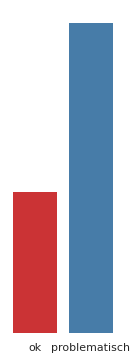

In [29]:
fig = plt.figure(1,figsize=(2,6))
ax = sns.barplot(['ok', 'problematisch'], [ float(predicted_probs[0].detach().numpy()),  float(predicted_probs[1].detach().numpy())], linewidth=0, palette='Set1')
sns.despine(fig=fig, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
ax.set_yticks([])
plt.savefig('rat_bert_bar_{}.png'.format(ex_id), format='png', transparent=True, dpi=360, bbox_inches='tight')

In [21]:
average_over_heads = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
average_over_heads.shape

(32, 25, 25)

In [32]:
averaged = attentions_mat.mean(axis=(1, 2))
averaged[31]

array([0.11143772, 0.11292811, 0.13985494, 0.07379081, 0.07697791,
       0.0628856 , 0.15064195, 0.08638836, 0.09543546, 0.08965905],
      dtype=float32)

<AxesSubplot:>

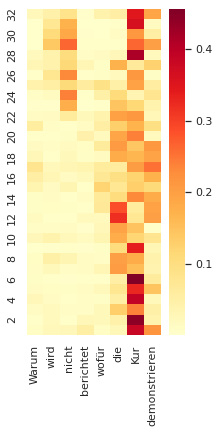

In [61]:
plt.figure(1,figsize=(3,6))
target = 7
lst = list(range(9))
lst.pop(target)
plot_attention_heatmap_input_ids(attentions_mat.mean(axis=1), 8*[target], lst, input_ids[0], tokenizer)

In [45]:
list(range(9)).remove(target)

In [38]:
8*[target]

[8, 8, 8, 8, 8, 8, 8, 8]

In [62]:
#@title Get raw attention mat + residual coonections

res_att_mat = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]
 
res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokenizer.decode(input_ids[0]))



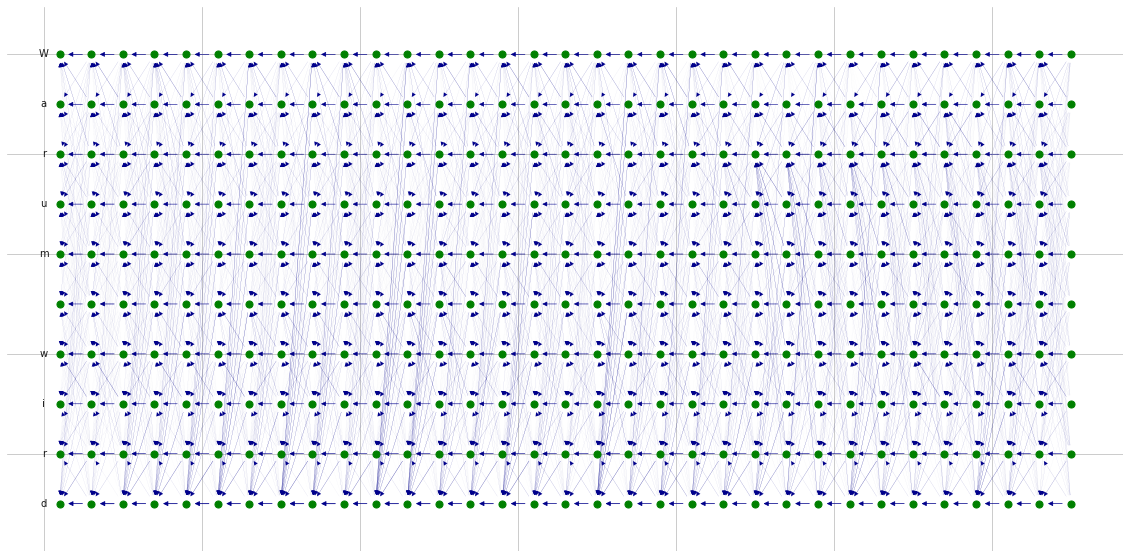

In [75]:
#@title plot the attention graph
plt.figure(figsize=(20,10))
res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])

<AxesSubplot:>

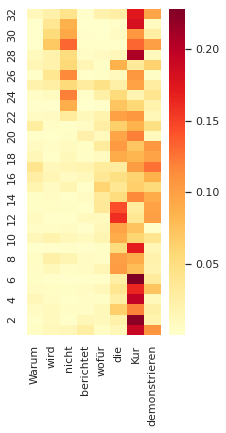

In [67]:
#@title Plot contrastive heatmap

plt.figure(1,figsize=(3,6))
target = 7
lst = list(range(9))
lst.pop(target)
plot_attention_heatmap_input_ids(res_att_mat, 8*[target], lst, input_ids[0], tokenizer)
# plot_attention_heatmap(res_att_mat, src[ex_id], t_positions=targets[ex_id], sentence=sentence)
#TODO: why is so much attention paid to "die" in this sentence??

In [68]:
#@title Compute attention rollout

joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)
joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=tokenizer.decode(input_ids[0]))


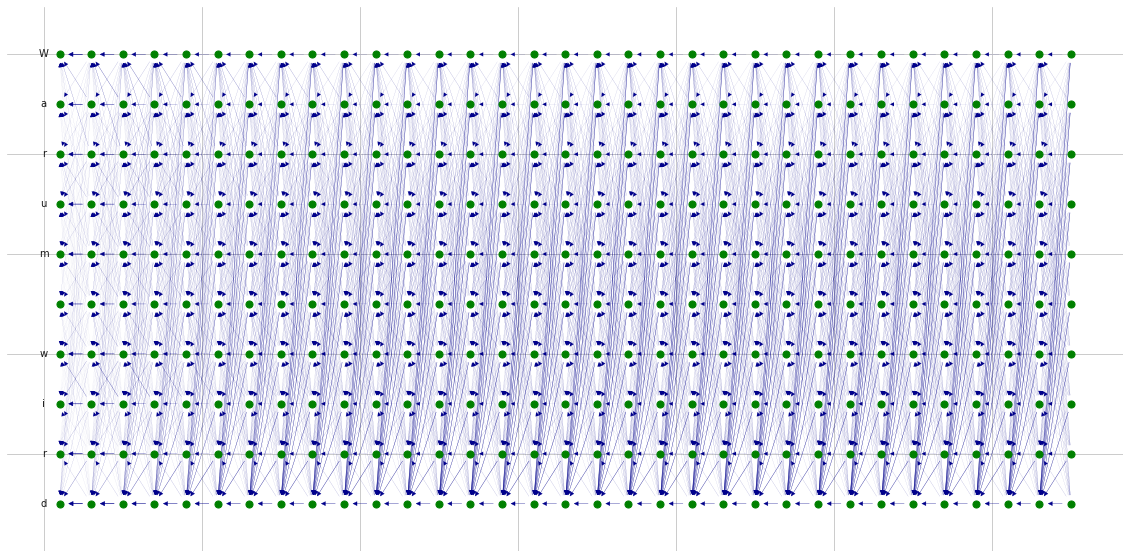

In [76]:
#@title Draw attention rollout graph
plt.figure(figsize=(20,10))
G = draw_attention_graph(joint_att_adjmat,joint_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])

<AxesSubplot:>

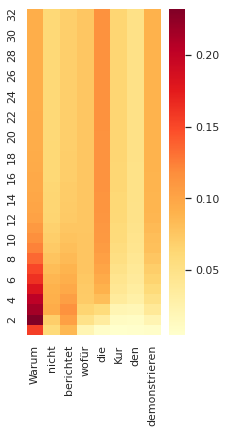

In [73]:
#@title Plot contrastive heatmap

plt.figure(1,figsize=(3,6))
target = 1
lst = list(range(9))
lst.pop(target)
plot_attention_heatmap_input_ids(joint_attentions, 8*[target], lst, input_ids[0], tokenizer)
# plot_attention_heatmap(joint_attentions, src[ex_id], t_positions=targets[ex_id], sentence=sentence)
#TODO: why is so much attention paid to "die" in this sentence?

In [77]:
#@title Compute attention flow (this will take quite some time to compute).

output_nodes = []
input_nodes = []
for key in res_labels_to_index:
    if 'L24' in key:
        output_nodes.append(key)
    if res_labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)

flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])


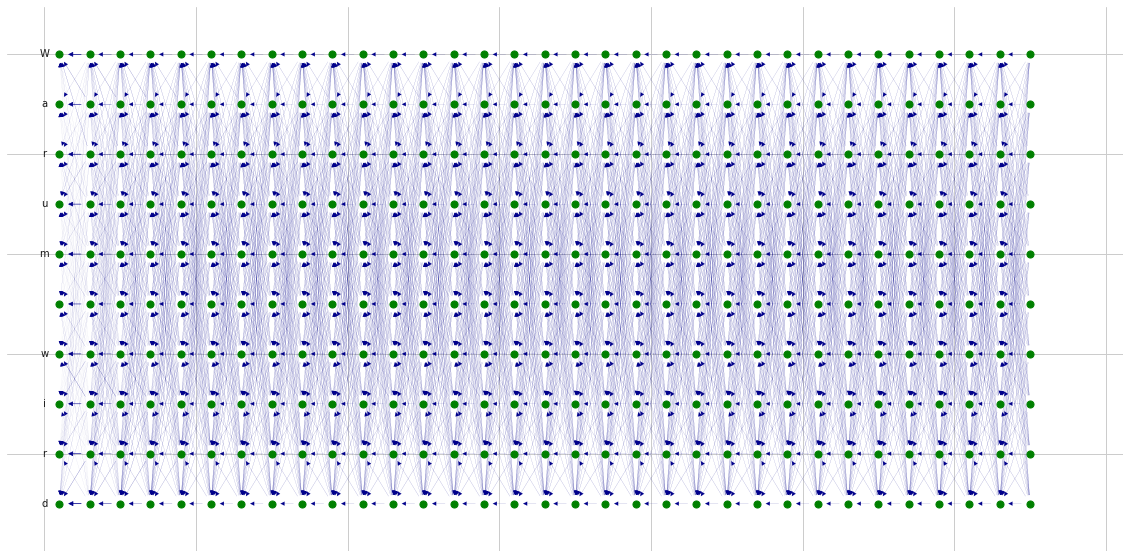

In [78]:
#@title Draw attention flow graph

plt.figure(figsize=(20,10))
flow_G = draw_attention_graph(flow_values,res_labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])

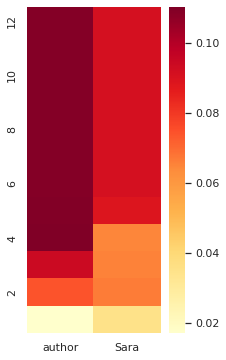

In [16]:
#@title Plot contrastive heatmap
flow_att_mat = convert_adjmat_tomats(flow_values, n_layers=attentions_mat.shape[0], l=attentions_mat.shape[-1])

plt.figure(1,figsize=(3,6))
plot_attention_heatmap(flow_att_mat, src[ex_id], t_positions=targets[ex_id], sentence=sentence)